# Endoscopy Access Modelling – Phase 2
**Notebook Objective**:  
Continue from Phase 1 to define and visualise population-based catchments, calculate rooms per 100k age 50–74 population, and classify access tiers for all LSOAs in the NHS South West region.

This notebook assumes prior exports were completed from the Phase 1 workbook:
- Facility locations with geometry
- Travel times (filtered to accessible journeys)
- LSOA population (age 50–74)
- Travel matrix with cumulative 50–74 reach

Steps in this notebook:
1. Load processed inputs
2. Define catchment rings per room (100k rule)
3. Visualise tiered catchments
4. Compute rooms per 100k aged 50+
5. Classify access tiers (low, marginal, adequate)
6. Visualise access tier maps
7. [Optional] Apply decay models (Gaussian, Huff)
8. Export tier maps and summary stats


In [11]:
# ----------------------------------------------------------
# Step 0 – Imports and File Paths
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Optional: Configure plotting style
plt.style.use("seaborn-v0_8-whitegrid")

# Define import directory (from Phase 1 exports)
import_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand/data/processed/endoscopy"

# File paths
facilities_path = os.path.join(import_dir, "facilities_with_geometry.gpkg")
travel_path = os.path.join(import_dir, "travel_times_filtered.csv")
lsoa_path = os.path.join(import_dir, "lsoa_population_50_74.geojson")
cumulative_path = os.path.join(import_dir, "travel_times_cumulative_50_74.csv")


In [12]:
# ----------------------------------------------------------
# Step 1 – Load Exported DataFrames
# ----------------------------------------------------------

# Load GeoDataFrames
facilities_gdf = gpd.read_file(facilities_path)
lsoa_gdf = gpd.read_file(lsoa_path)

# Load DataFrames
travel_df_filtered = pd.read_csv(travel_path)
travel_full_sorted = pd.read_csv(cumulative_path)

# Confirm successful load
print("Facilities:", facilities_gdf.shape)
print("LSOA Population:", lsoa_gdf.shape)
print("Travel Matrix (Filtered):", travel_df_filtered.shape)
print("Travel Matrix with Cumulative Reach:", travel_full_sorted.shape)


Facilities: (32, 13)
LSOA Population: (3451, 33)
Travel Matrix (Filtered): (34029, 5)
Travel Matrix with Cumulative Reach: (18398, 11)


In [13]:
# ----------------------------------------------------------
# Step 2 – Prepare LSOA-Level Lookup for Population & Geometry
# ----------------------------------------------------------

# Ensure LSOA code is string and trimmed for safety
lsoa_gdf["lsoa21cd"] = lsoa_gdf["lsoa21cd"].astype(str).str.strip()

# Create a simplified LSOA lookup for joining
lsoa_lookup = lsoa_gdf[["lsoa21cd", "pop_50_74", "geometry"]].copy()

# Confirm it looks correct
display(lsoa_lookup.head())


,lsoa21cd,pop_50_74,geometry
0,E01020484,568.83,"MULTIPOLYGON (((401918.077 78945.278, 401919.4..."
1,E01020481,643.13,"MULTIPOLYGON (((403211.07 78762.983, 403211.07..."
2,E01020482,608.53,"MULTIPOLYGON (((403126.904 78828.641, 403127.4..."
3,E01020479,419.26,"MULTIPOLYGON (((403027.597 79673.678, 403027.8..."
4,E01020478,464.03,"MULTIPOLYGON (((402493.1 79584.202, 402511.903..."


In [14]:
# ----------------------------------------------------------
# Step 3 – Re-Rank Travel Matrix by Facility and Travel Time
# ----------------------------------------------------------

# Ensure LSOA code column matches (destination_name = facility LSOA, origin_name = resident LSOA)
# First, re-merge population data (just to confirm alignment)
travel_ranked = travel_df_filtered.merge(
    lsoa_lookup[["lsoa21cd", "pop_50_74"]],
    left_on="origin_name",
    right_on="lsoa21cd",
    how="left"
)

# Confirm population successfully merged
if travel_ranked["pop_50_74"].isnull().any():
    print("Warning: Some origin LSOAs are missing 50–74 population data")

# Drop any rows without population (optional, or set to zero)
travel_ranked["pop_50_74"] = travel_ranked["pop_50_74"].fillna(0)

# Sort by facility (destination_name) and travel time (car)
travel_ranked = travel_ranked.sort_values(by=["destination_name", "travel_time_car"])

# Compute cumulative 50–74 population per facility catchment
travel_ranked["cum_pop_50_74"] = (
    travel_ranked.groupby("destination_name")["pop_50_74"].cumsum()
)

# Confirm structure
display(travel_ranked.head())

# Optional: Save for re-use in Step 5
travel_full_sorted = travel_ranked.copy()


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,lsoa21cd,pop_50_74,cum_pop_50_74
30381,E01014428,E01014428,0.000000,0.000000,0.000000,E01014428,400.94,400.94
7264,E01014427,E01014428,2.853522,7.793522,7.903522,E01014427,332.76,733.70
9794,E01014480,E01014428,3.083787,5.693787,7.693787,E01014480,362.26,1095.96
30382,E01014429,E01014428,3.416906,10.666906,10.666906,E01014429,452.83,1548.79
9628,E01014405,E01014428,3.557317,6.747317,7.747317,E01014405,544.42,2093.21


In [15]:
# ----------------------------------------------------------
# Step 4 – Define Population-Based Catchment Rings per Facility
# ----------------------------------------------------------

population_thresholds = [100_000, 200_000, 300_000]
catchments_list = []

for facility_code in travel_ranked["destination_name"].unique():
    df_facility = travel_ranked[travel_ranked["destination_name"] == facility_code].copy()

    # Re-sort just in case (essential)
    df_facility = df_facility.sort_values(by="travel_time_car")

    # Recompute cumulative population (defensive coding)
    df_facility["cum_pop_50_74"] = df_facility["pop_50_74"].cumsum()

    for i, threshold in enumerate(population_thresholds, start=1):
        df_ring = df_facility[df_facility["cum_pop_50_74"] <= threshold].copy()
        df_ring["catchment_ring"] = f"Ring {i} – up to {threshold/1000:.0f}k"

        if not df_ring.empty:
            catchments_list.append(df_ring)

# Combine all rings
catchments_df = pd.concat(catchments_list, ignore_index=True)

display(catchments_df.head())
print(f"Catchment DataFrame created with {catchments_df.shape[0]:,} rows across {len(population_thresholds)} rings.")


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,lsoa21cd,pop_50_74,cum_pop_50_74,catchment_ring
0,E01014428,E01014428,0.000000,0.000000,0.000000,E01014428,400.94,400.94,Ring 1 – up to 100k
1,E01014427,E01014428,2.853522,7.793522,7.903522,E01014427,332.76,733.70,Ring 1 – up to 100k
2,E01014480,E01014428,3.083787,5.693787,7.693787,E01014480,362.26,1095.96,Ring 1 – up to 100k
3,E01014429,E01014428,3.416906,10.666906,10.666906,E01014429,452.83,1548.79,Ring 1 – up to 100k
4,E01014405,E01014428,3.557317,6.747317,7.747317,E01014405,544.42,2093.21,Ring 1 – up to 100k


Catchment DataFrame created with 28,084 rows across 3 rings.


In [16]:
# ----------------------------------------------------------
# Step 4a – Merge Population Data into Travel Matrix
# ----------------------------------------------------------

travel_ranked = travel_df_filtered.merge(
    lsoa_lookup[["lsoa21cd", "pop_50_74"]],
    left_on="origin_name",
    right_on="lsoa21cd",
    how="left"
)

# Confirm successful merge
if travel_ranked["pop_50_74"].isnull().any():
    print("Warning: Some origin LSOAs are missing 50–74 population data.")

# Fill missing values defensively
travel_ranked["pop_50_74"] = travel_ranked["pop_50_74"].fillna(0)

# Sort by facility and travel time
travel_ranked = travel_ranked.sort_values(by=["destination_name", "travel_time_car"]).copy()


In [17]:
# ----------------------------------------------------------
# Step 5 – Define Population-Based Catchment Rings per Room (with travel time cap)
# ----------------------------------------------------------

catchment_rows = []
threshold_per_room = 100_000
min_threshold = 1_000  # fallback if not enough population

TRAVEL_TIME_CAP = 120  # max car time in minutes for any catchment

for facility_id, group in travel_ranked.groupby("destination_name"):
    facility = facilities_gdf[facilities_gdf["lsoa21cd"] == facility_id]
    if facility.empty:
        continue

    rooms = facility["Endoscopy Rooms"].values[0]
    pop_threshold = rooms * threshold_per_room

    # --- New: filter group to max allowed travel time ---
    group_filtered = group[group["travel_time_car"] <= TRAVEL_TIME_CAP].copy()

    # Defensive: if group becomes empty, skip
    if group_filtered.empty:
        continue

    group_sorted = group_filtered.sort_values("travel_time_car").copy()
    group_sorted["cum_pop_50_74"] = group_sorted["pop_50_74"].cumsum()

    if group_sorted["cum_pop_50_74"].iloc[-1] >= min_threshold:
        group_sorted = group_sorted[
            group_sorted["cum_pop_50_74"] <= pop_threshold
        ].copy()
        group_sorted["ring_level"] = (group_sorted["cum_pop_50_74"] // threshold_per_room).astype(int) + 1
    else:
        group_sorted["ring_level"] = 1

    group_sorted["facility_lsoa21cd"] = facility_id
    group_sorted["rooms_at_facility"] = rooms
    catchment_rows.append(group_sorted)

# Combine all facilities
catchments_df = pd.concat(catchment_rows, ignore_index=True)

print(f"Catchments created: {catchments_df.shape[0]:,} rows (max 00-min car travel)")
display(catchments_df.head())


Catchments created: 12,233 rows (max 60-min car travel)


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,lsoa21cd,pop_50_74,cum_pop_50_74,ring_level,facility_lsoa21cd,rooms_at_facility
0,E01014428,E01014428,0.000000,0.000000,0.000000,E01014428,400.94,400.94,1,E01014428,4
1,E01014427,E01014428,2.853522,7.793522,7.903522,E01014427,332.76,733.70,1,E01014428,4
2,E01014480,E01014428,3.083787,5.693787,7.693787,E01014480,362.26,1095.96,1,E01014428,4
3,E01014429,E01014428,3.416906,10.666906,10.666906,E01014429,452.83,1548.79,1,E01014428,4
4,E01014405,E01014428,3.557317,6.747317,7.747317,E01014405,544.42,2093.21,1,E01014428,4


In [18]:
# ----------------------------------------------------------
# Step 6 – Visualise Tiered Catchments with Categorised Facilities
# ----------------------------------------------------------

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# 1. Merge LSOA geometry into catchment data
catchments_df = catchments_df.merge(
    lsoa_gdf[["lsoa21cd", "geometry"]],
    how="left",
    left_on="lsoa21cd",
    right_on="lsoa21cd"
)

# 2. Convert to GeoDataFrame
catchments_gdf = gpd.GeoDataFrame(
    catchments_df,
    geometry="geometry",
    crs=lsoa_gdf.crs
)

# 3. Confirm structure
print("Catchment GeoDataFrame ready:")
print(catchments_gdf.columns)
print(catchments_gdf.geometry.head())
print("CRS:", catchments_gdf.crs)


Catchment GeoDataFrame ready:
Index(['origin_name', 'destination_name', 'travel_time_car',
       'travel_time_pt_peak', 'travel_time_pt_nonpeak', 'lsoa21cd',
       'pop_50_74', 'cum_pop_50_74', 'ring_level', 'facility_lsoa21cd',
       'rooms_at_facility', 'geometry'],
      dtype='object')
0    MULTIPOLYGON (((372963.403 166254.097, 372970....
1    MULTIPOLYGON (((372850.035 165304.68, 372851.6...
2    MULTIPOLYGON (((373180.639 166552.239, 373181....
3    MULTIPOLYGON (((372342.435 165587.873, 372342....
4    MULTIPOLYGON (((373203.512 165940.332, 373205....
Name: geometry, dtype: geometry
CRS: EPSG:27700


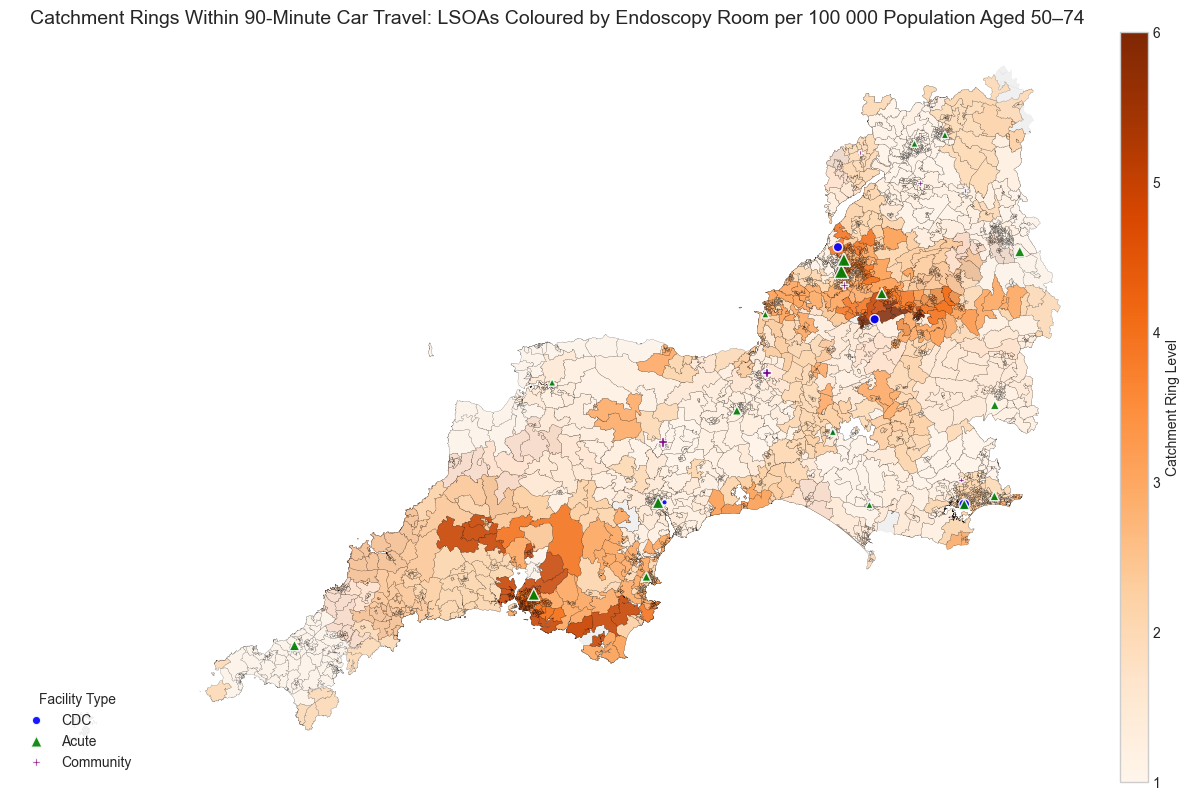

In [20]:
# ----------------------------------------------------------
# Step 6.1 – Plot Tiered Catchments with Facility Markers
# ----------------------------------------------------------

fig, ax = plt.subplots(1, 1, figsize=(12, 12))

# 1. Plot background LSOA layer
lsoa_gdf.plot(ax=ax, color="#f0f0f0", linewidth=0.1, edgecolor="lightgrey")

# 2. Plot catchments by ring level
catchments_gdf.plot(
    column="ring_level",
    cmap="Oranges",
    linewidth=0.1,
    edgecolor="black",
    ax=ax,
    alpha=0.85
)

# 3. Overlay facility markers (CDC, Acute, Community)
for label, colour, marker in [
    ("CDC", "blue", "o"),
    ("Acute", "green", "^"),
    ("Community", "purple", "P")
]:
    subset = facilities_gdf[facilities_gdf["source"] == label].copy()
    subset["centroid"] = subset.geometry.centroid
    subset.set_geometry("centroid", inplace=True)
    subset.plot(
        ax=ax,
        color=colour,
        markersize=subset["Endoscopy Rooms"] * 15,
        marker=marker,
        label=label,
        alpha=0.9,
        edgecolor="white"
    )

# 4. Title and legend
ax.set_title(
    "Catchment Rings Within 90-Minute Car Travel: LSOAs Coloured by Population Aged 50–74 per Endoscopy Room
",
    fontsize=14
)
ax.axis("off")
ax.legend(title="Facility Type", loc="lower left")

# 5. Add compact half-height colour bar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.1)

sm = plt.cm.ScalarMappable(
    cmap="Oranges",
    norm=plt.Normalize(
        vmin=catchments_gdf["ring_level"].min(),
        vmax=catchments_gdf["ring_level"].max()
    )
)
sm._A = []  # Dummy for colourbar
cbar = fig.colorbar(sm, cax=cax)
cbar.set_label("Catchment Ring Level")

# Resize colourbar to half height
box = cax.get_position()
cax.set_position([box.x0, box.y0 + box.height / 4, box.width, box.height / 2])

plt.tight_layout()
plt.show()


## Plot Explanation: Tiered Endoscopy Catchments by Population per Room

### Methodology (Technical)

- We define catchment rings around each diagnostic facility based on cumulative population aged 50–74 reachable within a 90-minute car travel time.
- The catchment ring levels correspond to population thresholds per endoscopy room (e.g., 100,000 people per room).
- LSOAs (Lower Layer Super Output Areas) within each catchment ring are coloured according to their ring level.
- Darker colours indicate higher ring levels, meaning more people aged 50–74 per available endoscopy room in that area.
- Facility types (CDC, Acute, Community) are overlaid with distinct markers sized proportionally to the number of endoscopy rooms.

### Plain Language Summary

- This map shows how many people aged between 50 and 74 are served by each endoscopy room within a 90-minute drive.
- Darker orange areas mean there are more people relying on each endoscopy room, which can indicate higher demand and possible pressure on services.
- Lighter areas suggest fewer people per room, implying better access and less strain on the facilities.
- The map also shows where different types of facilities are located, helping visualise service distribution.

### Evaluation of the Plot

- The plot effectively visualises spatial variation in service demand pressure across the region.
- Dark areas highlight potential hotspots where additional endoscopy capacity or service improvements may be required.
- Overlaying facility types clarifies service provider roles and helps stakeholders identify gaps.
- However, the discrete ring classification simplifies continuous demand gradients and may mask small-scale access nuances.
- The 90-minute travel time cap reflects a practical access limit, but some LSOAs beyond this are excluded, which could omit populations with very poor access.
- Overall, the map is a valuable tool for strategic planning and resource allocation in endoscopy services.
